# **The Business Case: "Customer Churn"**
Customers are cancelling their service ("Churning") to go to competitors. The Marketing Director is panicking. As a Data Analyst, my mission is:
* **Analyze**: Why are they leaving? (Is it price? Bad Service? Fiber optic issue?)
* **Predict**: Build a Machien Learning model to flag customers who are about to leave next month.
* **Recommend**: Tell the marketing team exactly who to call and what discount to offer.

**Dataset**: [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn)

---

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

#### **Step 1: Check the Data**

In [67]:
# Load Data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [68]:
print(f"Data shape: {df.shape}")
print(f"Data Info: {df.info()}")
print(f"\nNumber of NULL:\n{df.isna().sum()}")

Data shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

#### **Step 2: Fix the Data**

`TotalCharges` column data type seems to be object, let's convert it to numeric.

In [69]:
# Convert 'TotalCharges' column to numerical
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
print(f"Missing values: {df['TotalCharges'].isna().sum()}")

Missing values: 11


Since it's converted to numeric, there are only 11 missing values (NaN) out of ~7000 rows. Let's just drop it!

In [70]:
# Drop missing values
df.dropna(inplace=True)

# Let's drop ID column, since it won't needed for prediction
df.drop(columns=['customerID'], inplace=True)

print(f"New Shape: {df.shape}")

New Shape: (7032, 20)


##### **Encode**
Let's convert `Churn` column form **Yes/No** into **1/0** so later the model can understand.

In [71]:
# Convert Target to Numbers
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

---

#### **Step 3: Exploratory Data Analysis (EDA)**

Let's calculate the *Churn Rate*, and visualize to see how many customers are leaving.


Churn Rate:
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


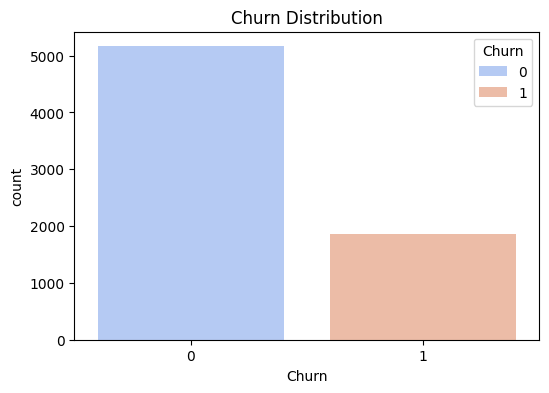

In [72]:
# Calculate the Churn Rate
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(f"Churn Rate:\n{churn_rate}")

# Visualize
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='coolwarm', hue='Churn')
plt.title("Churn Distribution")
plt.show()

About 26% of people leave. Let's Find out **WHY** they are leaving. There are three hypotheses that needs to be verified:
1. **Contract**: Do people with "Month-to-Month" contacts leave more?
2. **Internet**: Does "Fiber optic" internet cause more churn (maybe it's expensive or buggy)?
3. **Tenure**: Do new customers leave faster than loyan ones?

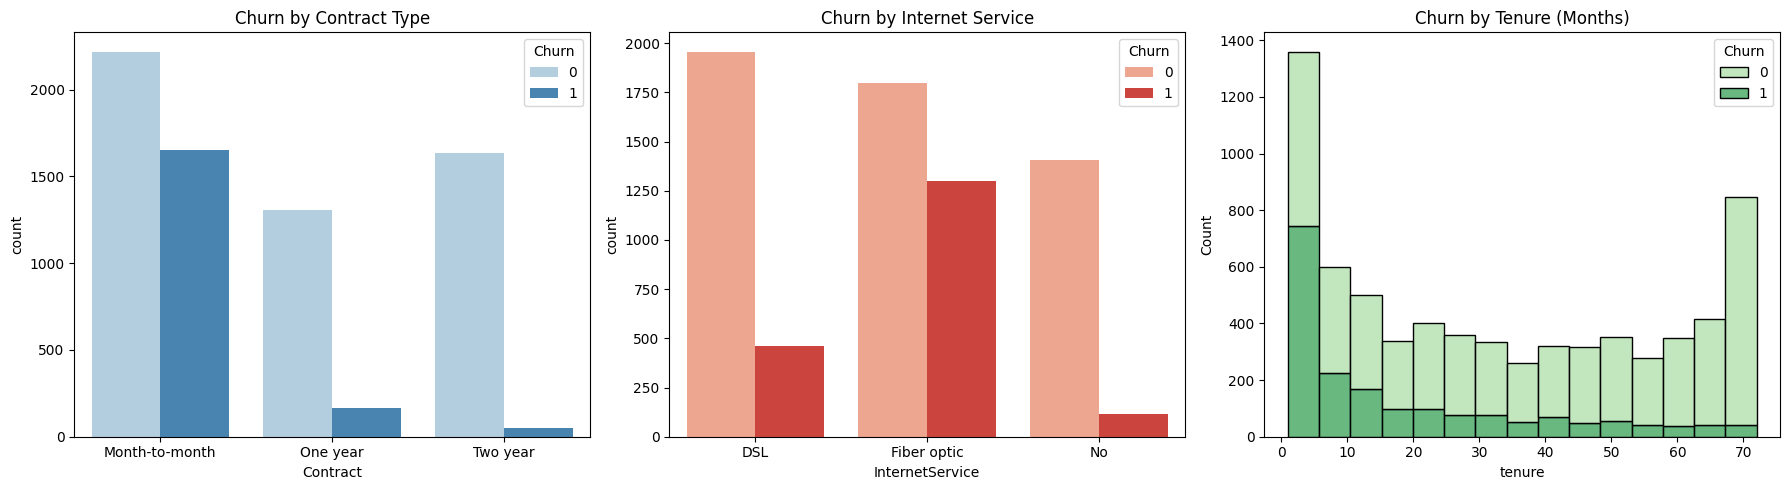

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

# Plot 1: Contract Type
sns.countplot(x='Contract', hue='Churn', data=df, ax=ax[0], palette='Blues')
ax[0].set_title('Churn by Contract Type')

# Plot 2: Internet Service
sns.countplot(x='InternetService', hue='Churn', data=df, ax=ax[1], palette='Reds')
ax[1].set_title('Churn by Internet Service')

# Plot 3: Tenure (Histogram)
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack',
             ax=ax[2], palette='Greens')
ax[2].set_title('Churn by Tenure (Months)')

plt.tight_layout()
plt.show()

1. **Month-to-Month Contracts**: People who chose monthly contract has higher churn rate.
2. **Fiber Optic**: Usually, fiber is the "premium" product. High churn here likely means it's **too expensive** or **unreliable**. (A warning for the tech team)
3. **New Customers**: If they survice the first 12 months, they tend to stay. The danger zone is the first year (12 months).

---

#### **Step 4: Preprocessing**
Before building the model, the categorical columns needs to be *encoded* (*translate* categorical columns into numeric), it will help the model to learn the data correctly.

**Method**: "One-Hot Encoding"

In [74]:
# Seperate the colums into "Numerical" and "Categorical"
num_cols = list(df.select_dtypes('number').columns)
num_cols.remove('Churn')
cat_cols = list(df.select_dtypes('object').columns)

# Convert text categories to numbers (One-Hot Encoding)
df_clean = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check
print(f"Old Shape: {df.shape}")
print(f"New Shape: {df_clean.shape}")

# Scale the Numerical Columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])

df_clean.head()

Old Shape: (7032, 20)
New Shape: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.440327,-1.280248,-1.161694,-0.994194,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,-0.440327,0.064303,-0.260878,-0.173740,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,-0.440327,-1.239504,-0.363923,-0.959649,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,-0.440327,0.512486,-0.747850,-0.195248,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,-0.440327,-1.239504,0.196178,-0.940457,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False


---

#### **The Baseline Model**
Always start with a simple model to set a "Baseline". If a fancy Deep Learning model can't beat simple Logistic Regression, it's not worth the effort.

Task:
1. Split data into **Train** (80%) and **Test** (20%)
2. Train a **Logistic Regression** model.
3. Check the accuracy.

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define X (Features) and y (Target)
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

# Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model_lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {acc:.2%}")
print(f"\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Baseline Accuracy: 78.75%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



**78.75%** Accuracy looks good, but the **Recall** for Class 1 (Churn): **0.52**. It means:

* Out of 100 people who are about to quit, the model only spots **52** of them.
* The model didn't notice let 48% of the churning customers.

We need a model that doesn't just draw a straight lines. We need a model that can handle complex, messy rules.

---

#### **Random Forest**
Swap the model from "**Logistic Regression**" (Simple Math) to "**Random Forest**" (Decision Tree)
* It builds 100 different "Decision Trees" (flowcharts) and lets them vote.
* It capture non-linear patterns (e.g., "If tenure <5 AND contract is Mont-to-Month, THEN High Risk of Churning).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest